In [34]:
# Download the dataset to __dataset__ folder.
# http://fsoco.cs.uni-freiburg.de/datasets/fsoco_segmentation_train.zip


def download_dataset(url: str, destination_folder: str):
    import os
    import requests
    import zipfile

    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # If meta.json exists, then the dataset has been downloaded.
    if os.path.exists(os.path.join(destination_folder, "meta.json")):
        print("Dataset has been downloaded.")
        return

    filename = url.split("/")[-1]
    filepath = os.path.join(destination_folder, filename)

    if not os.path.exists(filepath):
        print("Downloading dataset...")
        r = requests.get(url, stream=True)
        with open(filepath, "wb") as f:
            for chunk in r.iter_content(chunk_size=1024):
                if chunk:
                    f.write(chunk)

    print("Extracting dataset...")
    with zipfile.ZipFile(filepath) as zf:
        zf.extractall(destination_folder)

    print("Done.")

    # Remove the zip file.
    os.remove(filepath)


download_dataset(
    "http://fsoco.cs.uni-freiburg.de/datasets/fsoco_bounding_boxes_train.zip",
    "__dataset__/boxes/supervisely",
)

Dataset has been downloaded.


In [35]:
from supervisely_yolo_multiple import S2Y
import os
import glob


# Convert the dataset to YOLO format.
def convert_to_yolo(source_folder: str, destination_folder: str):


    # Create data.yaml file.
    if os.path.exists(destination_folder):
        print("YOLO structure already exists.")
        return

    converter = S2Y(source_folder, destination_folder, skip_copy=True)
    class_names_array = converter.get_class_names_from_supervisely()
    converter.create_yolo_file_structure()
    converter.create_class_file(class_names_array)

    dataset_folders = [
        folder for folder in os.listdir(converter.supervisely_path)
    ]

    for folder in dataset_folders:
        labels_path = converter.supervisely_path + '/' + folder + "//ann"
        print("labels_path", labels_path)
        for file_path in glob.glob(os.path.join(labels_path, "*.json")):
            with open(file_path) as file:
                file_name = os.path.basename(file.name)[:-5]
                converter.create_text_file(folder, file_name, class_names_array)
        print("Yolo structure created at => {}".format(converter.yolo_path))


convert_to_yolo("__dataset__/boxes/supervisely", "__dataset__/boxes/yolo")

YOLO structure already exists.


In [36]:
import random
import shutil
import yaml
import os

# Create the data.yaml file and split into train, test and validate.
def set_up_dataset(yolo_folder: str):
    if os.path.exists(yolo_folder + "/data.yaml"):
        print("data.yaml already exists.")
        return

    # Create the train, test and validate folders.
    folders = ["train", "test", "validate"]
    for folder in folders:
        if not os.path.exists(yolo_folder + '/' + folder):
            os.makedirs(yolo_folder + "/" + folder)
            os.makedirs(yolo_folder + "/" + folder + "/images")
            os.makedirs(yolo_folder + "/" + folder + "/labels")

    # Copy the images and labels to the train, test and validate folders.
    if os.path.exists(yolo_folder + "/images"):
        for file in os.listdir(yolo_folder + "/images"):

            # Take a random number between 0 and 2.
            random_number = random.randint(0, 2)
            destination_folder = yolo_folder + '/' + folders[random_number]

            # Copy the image and the label to the destination folder.
            shutil.move(yolo_folder + "/images/" + file, destination_folder + "/images/" + file)
            file_name_without_extension = os.path.splitext(file)[0]
            shutil.move(yolo_folder + "/labels/" + file_name_without_extension + ".txt", destination_folder + "/labels/" + file_name_without_extension + ".txt")

    # Move classes.txt to the base folder.
    if not os.path.exists(yolo_folder + "/classes.txt"):
        shutil.move(yolo_folder + "/labels/classes.txt", yolo_folder + "/classes.txt")

    # Remove the images and labels folder.
    if os.path.exists(yolo_folder + "/images"):
        shutil.rmtree(yolo_folder + "/images")

    if os.path.exists(yolo_folder + "/labels"):
        shutil.rmtree(yolo_folder + "/labels")

    # Read the classes from the classes.txt file.
    with open(yolo_folder + "/classes.txt", "r") as file:
        classes = file.read().splitlines()

    # Create the data.yaml file.
    data = dict(
        names = classes,
        nc = len(classes),
        test = yolo_folder + "/test/images",
        train = yolo_folder + "/train/images",
        val = yolo_folder + "/validate/images"
    )

    with open(yolo_folder + "/data.yaml", 'w') as outfile:
        yaml.dump(data, outfile)


set_up_dataset("__dataset__/boxes/yolo")

data.yaml already exists.


In [12]:
# !pip install ultralytics
import os
from ultralytics import YOLO

# Training.
# Check if best weights exist.
notebook_path = os.getcwd()
best_path = notebook_path + '/__models__/cones/weights/best.pt'
if os.path.exists(best_path):
    print("Best weights already exist.")
    model = YOLO(best_path)
else:
    model = YOLO("yolov8n.yaml")

results = model.train(data=notebook_path + '/__dataset__/boxes/yolo/data.yaml', epochs=100, imgsz=128, resume=True, project=notebook_path + '/__models__/', name='cones')


Best weights already exist.
Ultralytics YOLOv8.1.5 🚀 Python-3.12.1 torch-2.3.0.dev20240123 CPU (Apple M1)
engine/trainer: task=detect, mode=train, model=/Users/riccardopersello/Developer/daml-notebooks/exam/__models__/cones/weights/best.pt, data=/Users/riccardopersello/Developer/daml-notebooks/exam/__dataset__/boxes/yolo/data.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=128, save=True, save_period=-1, cache=False, device=None, workers=0, project=/Users/riccardopersello/Developer/daml-notebooks/exam/__models__/, name=cones, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=None, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vis

train: Scanning /Users/riccardopersello/Developer/daml-notebooks/exam/__dataset__/boxes/yolo/train/labels.cache... 3865 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3865/3865 [00:00<?, ?it/s]
val: Scanning /Users/riccardopersello/Developer/daml-notebooks/exam/__dataset__/boxes/yolo/validate/labels.cache... 3944 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3944/3944 [00:00<?, ?it/s]

Plotting labels to /Users/riccardopersello/Developer/daml-notebooks/exam/__models__/cones/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Resuming training from /Users/riccardopersello/Developer/daml-notebooks/exam/__models__/cones/weights/best.pt from epoch 2 to 100 total epochs
Image sizes 128 train, 128 val
Using 0 dataloader workers
Logging results to /Users/riccardopersello/Developer/daml-notebooks/exam/__models__/cones
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      3.307      4.143      1.158         53        128: 100%|██████████| 242/242 [04:08<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [02:59<00:00,  1.45s/it]

                   all       3944      75264     0.0182     0.0337     0.0125    0.00399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G       3.44       2.84      1.075         54        128: 100%|██████████| 242/242 [04:06<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [03:00<00:00,  1.46s/it]

                   all       3944      75264      0.278     0.0349     0.0194     0.0061



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      3.002      2.203     0.9782         51        128: 100%|██████████| 242/242 [04:10<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 124/124 [03:03<00:00,  1.48s/it]


                   all       3944      75264      0.404     0.0439     0.0336     0.0126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      2.787      1.884     0.9357         85        128:  58%|█████▊    | 140/242 [02:26<01:46,  1.04s/it]


KeyboardInterrupt: 


image 1/1 /Users/riccardopersello/Developer/daml-notebooks/exam/__dataset__/boxes/yolo/test/images/mad_amz_02795.png: 64x128 1 blue_cone, 5.3ms
Speed: 0.3ms preprocess, 5.3ms inference, 0.4ms postprocess per image at shape (1, 3, 64, 128)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([7.])
conf: tensor([0.3468])
data: tensor([[1.8522e+03, 3.3536e+02, 1.9362e+03, 4.2484e+02, 3.4683e-01, 7.0000e+00]])
id: None
is_track: False
orig_shape: (920, 2872)
shape: torch.Size([1, 6])
xywh: tensor([[1894.2255,  380.1001,   83.9783,   89.4727]])
xywhn: tensor([[0.6595, 0.4132, 0.0292, 0.0973]])
xyxy: tensor([[1852.2363,  335.3637, 1936.2146,  424.8365]])
xyxyn: tensor([[0.6449, 0.3645, 0.6742, 0.4618]])


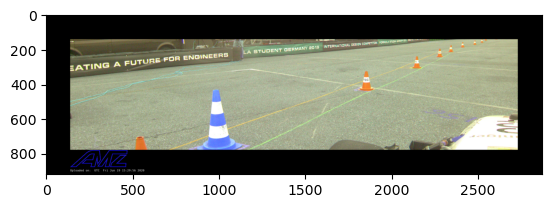


image 1/1 /Users/riccardopersello/Developer/daml-notebooks/exam/__dataset__/boxes/yolo/test/images/mms_mms_00155.jpg: 128x128 1 blue_cone, 12.3ms
Speed: 0.5ms preprocess, 12.3ms inference, 0.3ms postprocess per image at shape (1, 3, 128, 128)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([7.])
conf: tensor([0.7768])
data: tensor([[8.5769e+02, 9.5559e+02, 9.7738e+02, 1.0892e+03, 7.7685e-01, 7.0000e+00]])
id: None
is_track: False
orig_shape: (1304, 1560)
shape: torch.Size([1, 6])
xywh: tensor([[ 917.5374, 1022.4138,  119.6903,  133.6546]])
xywhn: tensor([[0.5882, 0.7841, 0.0767, 0.1025]])
xyxy: tensor([[ 857.6922,  955.5865,  977.3825, 1089.2411]])
xyxyn: tensor([[0.5498, 0.7328, 0.6265, 0.8353]])


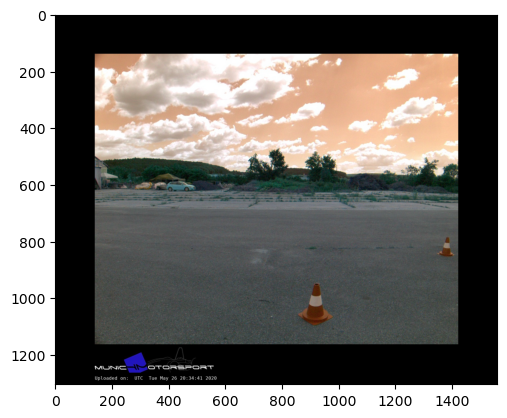


image 1/1 /Users/riccardopersello/Developer/daml-notebooks/exam/__dataset__/boxes/yolo/test/images/bme_bme_00138.jpg: 64x128 (no detections), 12.3ms
Speed: 0.4ms preprocess, 12.3ms inference, 0.4ms postprocess per image at shape (1, 3, 64, 128)


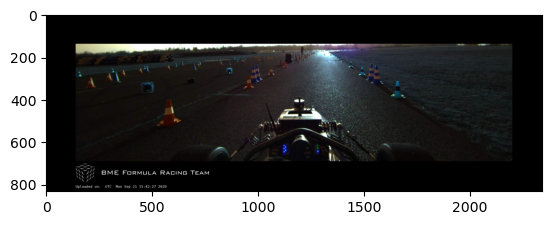


image 1/1 /Users/riccardopersello/Developer/daml-notebooks/exam/__dataset__/boxes/yolo/test/images/ulm_ulm_00035.jpg: 96x128 1 yellow_cone, 1 blue_cone, 10.9ms
Speed: 0.8ms preprocess, 10.9ms inference, 0.4ms postprocess per image at shape (1, 3, 96, 128)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([2.])
conf: tensor([0.6249])
data: tensor([[1.0533e+03, 3.3857e+02, 1.1496e+03, 4.4736e+02, 6.2487e-01, 2.0000e+00]])
id: None
is_track: False
orig_shape: (1000, 1552)
shape: torch.Size([1, 6])
xywh: tensor([[1101.4103,  392.9673,   96.2937,  108.7946]])
xywhn: tensor([[0.7097, 0.3930, 0.0620, 0.1088]])
xyxy: tensor([[1053.2634,  338.5700, 1149.5571,  447.3646]])
xyxyn: tensor([[0.6786, 0.3386, 0.7407, 0.4474]])
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([7.])
conf: tensor([0.4561])
data: tensor([[5.2998e+02, 3.2834e+02, 6.4574e+02, 4.5354e+02, 4.5606e-01, 7.0000e+00]])
id: None
is_track: False
orig_shape: (1000, 1552)
shape: torch.Size([

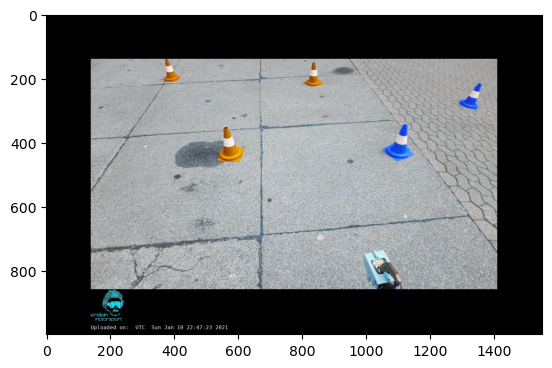


image 1/1 /Users/riccardopersello/Developer/daml-notebooks/exam/__dataset__/boxes/yolo/test/images/amz_amz_00247.png: 96x128 1 yellow_cone, 5.9ms
Speed: 0.4ms preprocess, 5.9ms inference, 0.3ms postprocess per image at shape (1, 3, 96, 128)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([2.])
conf: tensor([0.2811])
data: tensor([[5.1302e+02, 4.5320e+02, 5.7850e+02, 5.1776e+02, 2.8109e-01, 2.0000e+00]])
id: None
is_track: False
orig_shape: (1080, 1880)
shape: torch.Size([1, 6])
xywh: tensor([[545.7585, 485.4784,  65.4868,  64.5579]])
xywhn: tensor([[0.2903, 0.4495, 0.0348, 0.0598]])
xyxy: tensor([[513.0151, 453.1995, 578.5020, 517.7574]])
xyxyn: tensor([[0.2729, 0.4196, 0.3077, 0.4794]])


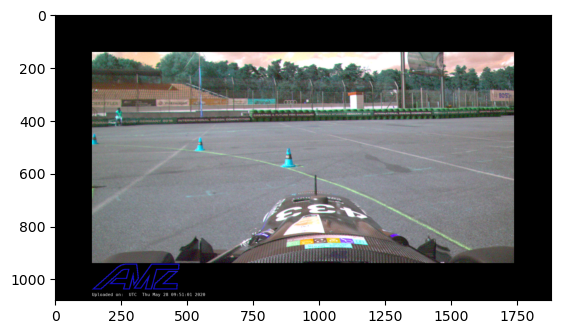


image 1/1 /Users/riccardopersello/Developer/daml-notebooks/exam/__dataset__/boxes/yolo/test/images/ugr_amz_02007.png: 64x128 (no detections), 10.8ms
Speed: 0.2ms preprocess, 10.8ms inference, 0.2ms postprocess per image at shape (1, 3, 64, 128)


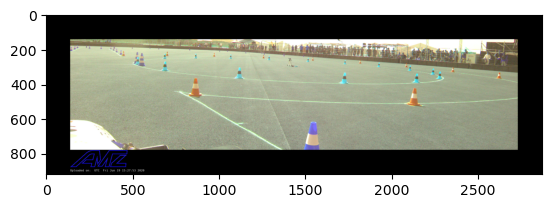


image 1/1 /Users/riccardopersello/Developer/daml-notebooks/exam/__dataset__/boxes/yolo/test/images/eco_eco_00271.png: 96x128 1 blue_cone, 6.8ms
Speed: 0.4ms preprocess, 6.8ms inference, 0.3ms postprocess per image at shape (1, 3, 96, 128)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([7.])
conf: tensor([0.4240])
data: tensor([[9.4512e+02, 8.0913e+02, 1.0757e+03, 9.6629e+02, 4.2401e-01, 7.0000e+00]])
id: None
is_track: False
orig_shape: (1368, 2200)
shape: torch.Size([1, 6])
xywh: tensor([[1010.3956,  887.7100,  130.5541,  157.1551]])
xywhn: tensor([[0.4593, 0.6489, 0.0593, 0.1149]])
xyxy: tensor([[ 945.1186,  809.1324, 1075.6727,  966.2875]])
xyxyn: tensor([[0.4296, 0.5915, 0.4889, 0.7064]])


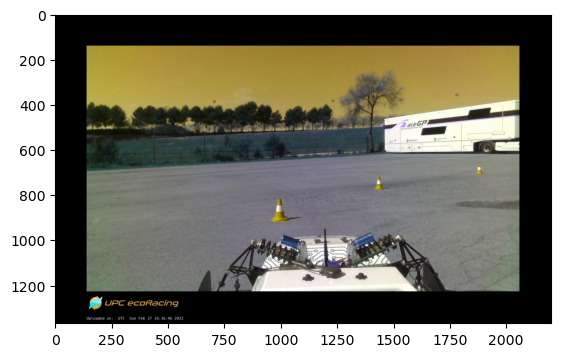


image 1/1 /Users/riccardopersello/Developer/daml-notebooks/exam/__dataset__/boxes/yolo/test/images/ecurieaix_ecurieaix_00245.png: 96x128 (no detections), 7.4ms
Speed: 0.5ms preprocess, 7.4ms inference, 0.2ms postprocess per image at shape (1, 3, 96, 128)


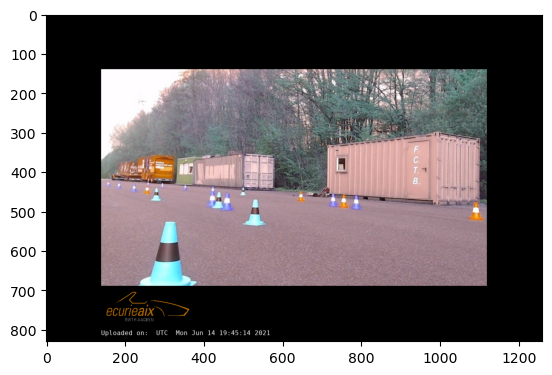


image 1/1 /Users/riccardopersello/Developer/daml-notebooks/exam/__dataset__/boxes/yolo/test/images/ecurieaix_ecurieaix_00251.png: 96x128 (no detections), 9.0ms
Speed: 0.4ms preprocess, 9.0ms inference, 0.2ms postprocess per image at shape (1, 3, 96, 128)


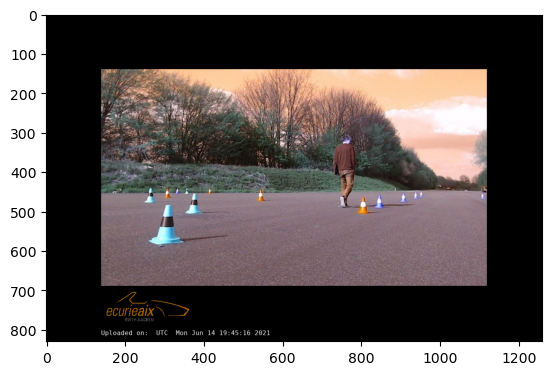


image 1/1 /Users/riccardopersello/Developer/daml-notebooks/exam/__dataset__/boxes/yolo/test/images/prom_prom_00004.jpg: 96x128 1 yellow_cone, 9.8ms
Speed: 0.8ms preprocess, 9.8ms inference, 0.4ms postprocess per image at shape (1, 3, 96, 128)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([2.])
conf: tensor([0.3928])
data: tensor([[1.1905e+03, 6.1104e+02, 1.2781e+03, 7.2801e+02, 3.9276e-01, 2.0000e+00]])
id: None
is_track: False
orig_shape: (1090, 1720)
shape: torch.Size([1, 6])
xywh: tensor([[1234.2690,  669.5234,   87.6180,  116.9719]])
xywhn: tensor([[0.7176, 0.6142, 0.0509, 0.1073]])
xyxy: tensor([[1190.4601,  611.0374, 1278.0781,  728.0093]])
xyxyn: tensor([[0.6921, 0.5606, 0.7431, 0.6679]])


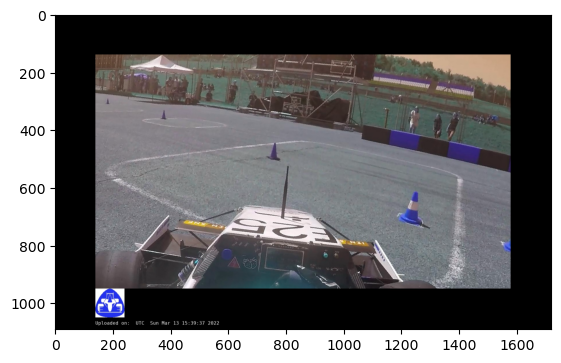


image 1/1 /Users/riccardopersello/Developer/daml-notebooks/exam/__dataset__/boxes/yolo/test/images/tuwr_tuwr_00349.jpg: 96x128 (no detections), 11.0ms
Speed: 0.7ms preprocess, 11.0ms inference, 0.2ms postprocess per image at shape (1, 3, 96, 128)


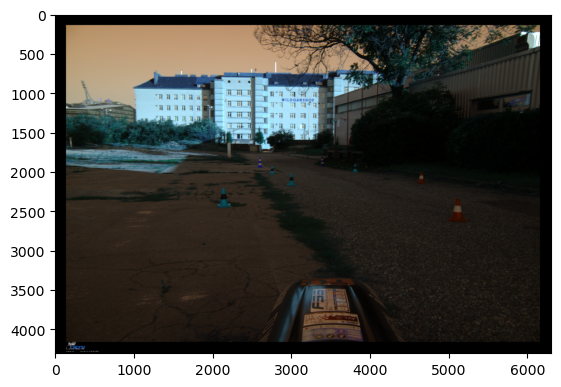

In [1]:
from cv2 import imread
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

notebook_path = os.getcwd()
best_path = notebook_path + '/__models__/cones/weights/best.pt'
model = YOLO(best_path)

# Test the model.
test_path = notebook_path + '/__dataset__/boxes/yolo/test/images'
for image in os.listdir(test_path):
    image_path = test_path + '/' + image
    results = model(image_path)

    # Show the image and draw the bounding boxes.
    image = imread(image_path)
    plt.imshow(image)

    for result in results:
        for box in result.boxes:
            print(box)

    plt.show()

    # Wait for user input.
    input("Press Enter to continue...")
    plt.close()